In [2]:
# This notebook displays the daily APY for a specific curve.fi pool.
# WIP.

# The following contract events are known to produce fees:
# - TokenExchange
# - TokenExchangeUnderlying
# - RemoveLiquidityOne
# - RemoveLiquidityImbalance
# - ??? Add more

# The fees are accrued in the form of the virtual price of the LP token.
# Use methodology from https://resources.curve.fi/lp/calculating-yield/#base-vapy
# contract.get_virtual_price(): uint256

In [ ]:
import os
import time
import matplotlib.pyplot as plt
from web3 import Web3, HTTPProvider
from datetime import datetime, timedelta
import json

# Provider setup
infura_url = os.getenv('NODE_URL_ETH')
web3 = Web3(HTTPProvider(infura_url))

# Contract setup
contract_address = '0xbEbc44782C7dB0a1A60Cb6fe97d0b483032FF1C7' # 3pool from main.json
with open('./curve_pools/abi/3pool.abi.json', 'r') as f:
    contract_abi = json.load(f)
contract = web3.eth.contract(address=contract_address, abi=contract_abi)

In [11]:
# Use fee generating events to calculate the daily APY.

# Recursively fetch events in smaller time intervals, if too many events are found
def getEventsRecursive(event, _from, _to):
    try:
        events = (
            event
            .create_filter(fromBlock=_from, toBlock=_to)
            .get_all_entries()
        )
        print("Found ", len(events), " events between blocks ", _from, " and ", _to)
        return events
    except ValueError:
        print("Too many events found between blocks ", _from, " and ", _to)
        midBlock = (_from + _to) // 2
        return getEventsRecursive(event, _from, midBlock) + getEventsRecursive(
            event, midBlock + 1, _to
        )

# Fetch 24h list of TokenExchange events emitted by the contract
current_block = web3.eth.block_number
start_block = current_block - (24 * 60 * 60 // 12) # 24h ago
events = getEventsRecursive(contract.events.TokenExchange(), start_block, current_block)


Found  4933  events between blocks  18176462  and  18399662


In [20]:
# Calculate the daily APY
# token_count = contract.functions.N_COINS().call()
n = 0
token_balance = []
for i in range(5): 
    try:
        token_count = contract.functions.balances(i).call()
        token_balance.append(token_count)
        n += 1
    except Exception:
        break
print("Token count: ", n)
print("Token balance: ", token_balance)
# WIP ...

Token balance:  [80429595771796166589664359, 78426779557924, 43245937699110]
Token count:  3


In [34]:
# Current virtual price
virtual_price = contract.functions.get_virtual_price().call()
print("Current virtual price: ", virtual_price)

# Yesterday's virtual price
current_block = web3.eth.block_number
yesterday_block = current_block - (24 * 60 * 60 // 12)
yesterday_virtual_price = contract.functions.get_virtual_price().call(block_identifier=yesterday_block)
print("Yesterday's virtual price: ", yesterday_virtual_price)

# Calculate the daily vAPY
vapy = (virtual_price / yesterday_virtual_price) ** 365 - 1
print("Current vAPY: ", vapy)
print("Current vAPY (in %): ", vapy * 100, "%")

Current virtual price:  1027717028118000177
Yesterday's virtual price:  1027712431518673758
Current vAPY:  0.0016338473443542334
Current vAPY (in %):  0.16338473443542334 %


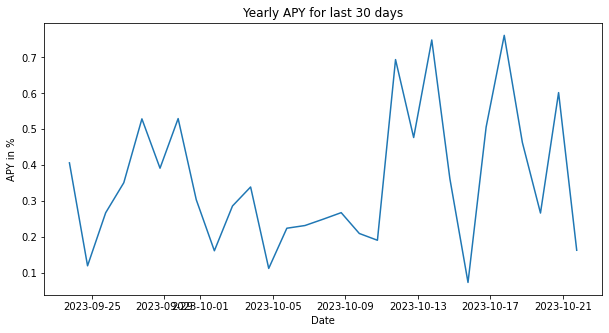

In [35]:
# Use virtual price to calculate fees accrued in the last N days

def calculate_apy_for_last_days(contract, days):
    current_block = web3.eth.block_number
    current_timestamp = time.time()
    # getting daily snapshot
    blocks = [current_block - (i * 60 * 60 * 24 // 12) for i in range(days)]
    virtual_prices = []
    for block in blocks:
        # fetching historic data
        virtual_price = contract.functions.get_virtual_price().call(block_identifier=block)
        virtual_prices.append(virtual_price)

    apys = []
    for i in range(len(virtual_prices)-1):
        # # daily percentage yield
        # apy = ((virtual_prices[i] - virtual_prices[i+1]) / virtual_prices[i+1]) * 100
        # # Convert to yearly. Compound interests.
        # apy = ((apy / 100) + 1) ** 365 - 1

        apy = (virtual_prices[i] / virtual_prices[i+1]) ** 365 - 1
        apy *= 100
        apys.append(apy)

    # Compute timestamps from block numbers. Use current timestamp for last block.
    timestamps = [current_timestamp - (i * 60 * 60 * 24) for i in range(days)]

    return timestamps[:-1], apys


ts, apys = calculate_apy_for_last_days(contract, 30)
dates = [datetime.fromtimestamp(t) for t in ts]

plt.figure(figsize=(10,5))
plt.plot(dates, apys)
plt.title('Yearly APY for last 30 days')
plt.xlabel('Date')
plt.ylabel('APY in %')
plt.show()